In [1]:
#from scipy.sparse.linalg import spsolve
#from scipy.sparse import csc_matrix
#import scipy.sparse as sparse
import scipy.linalg as linalg
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

In [2]:
def generateTriDiag(size, w):
    return np.diag(w*np.ones(size-1),-1) + np.diag(np.ones(size),0) + np.diag(w*np.ones(size-1),1)

def generateMat0(shuffle=False):
    Z = 1*np.eye(2*size) + np.triu(0.1*np.random.rand(2*size,2*size))
    if shuffle:
        Z = Z[:, np.random.permutation(Z.shape[1])]
        Z = Z + 2*np.eye(2*size)
    A = Z[:size,:size]
    B = Z[:size,size:] + 0.9*np.eye(size)
    Z[:size,size:] = B
    C = Z[size:,:size] + 0.4*np.eye(size)
    Z[size:,:size] = C
    D = Z[size:,size:]
    return A, B, C, D, Z

def generateMat1(w=0.1):
    A = generateTriDiag(size, w)
    B = np.eye(size)
    C = generateTriDiag(size, w)
    D = generateTriDiag(size, w)
    Z = np.zeros((2*size,2*size))
    Z[:size,:size] = A
    Z[:size,size:] = B
    Z[size:,:size] = C
    Z[size:,size:] = D
    return A, B, C, D, Z

In [3]:
def method_BlockGaussSeidel(nit, L):
    u = np.zeros(A.shape[0])
    v = np.zeros(A.shape[0])
    res = []
    for i in range(nit):
        u = linalg.solve(A + L*np.eye(A.shape[0]), f1 - np.dot(B, v) + L*u)
        v = linalg.solve(D, f2 - np.dot(C, u))
        res.append(np.linalg.norm(sol - np.concatenate((u,v))))
    return u, v, np.array(res)

def method_BlockJacobi(nit, L):
    u = np.zeros(A.shape[0])
    v = np.zeros(A.shape[0])
    u0 = np.zeros(A.shape[0])
    v0 = np.zeros(A.shape[0])
    res = []
    for i in range(nit):
        u = linalg.solve(A + L*np.eye(A.shape[0]), f1 - np.dot(B, v0) + L*u)
        v = linalg.solve(D, f2 - np.dot(C, u0))
        res.append(np.linalg.norm(sol - np.concatenate((u,v))))
        u0 = u
        v0 = v
    return u, v, np.array(res)
    
def method_ShurPartialJacobi(nit, L):
    DD    = np.diag(D.diagonal(),0)
    invDD = np.diag(1/D.diagonal(),0)
    u = np.zeros(A.shape[0])
    v = np.zeros(A.shape[0])
    res = []
    for i in range(nit):
        u = linalg.solve(
            A  - np.dot(B, np.dot(invDD ,C)) + L*np.eye(A.shape[0]), 
            f1 - np.dot(B, np.dot(invDD, f2 - np.dot(D-DD, v))) + L*u
        )
        v = linalg.solve(D, f2 - np.dot(C,u))
        res.append(np.linalg.norm(sol - np.concatenate((u,v))))
    return u, v, np.array(res)

def method_BlockSOR(nit, alpha):
    u = np.zeros(A.shape[0])
    v = np.zeros(A.shape[0])
    res = []
    for i in range(nit):
        delta_u = linalg.solve(A, f1 - np.dot(A, u) - np.dot(B, v))
        u = u + alpha*delta_u
        delta_v = linalg.solve(D, f2 - np.dot(C, u) - np.dot(D, v))
        v = v + delta_v
        #v = v + alpha*delta_v # this affects the choice of alpha
        res.append(np.linalg.norm(sol - np.concatenate((u,v))))

    return u, v, np.array(res)

In [4]:
size = 30

A, B, C, D, Z = generateMat0(shuffle=False)
#A, B, C, D, Z = generateMat1()

f1 = np.random.rand(size)
f2 = np.random.rand(size)
print("determinant of Z =", linalg.det(Z))
print("condition number of Z =", np.linalg.cond(Z))

f = np.concatenate((f1,f2))
sol = linalg.solve(Z, f)
print(f"monolithic error = {np.linalg.norm(f-np.dot(Z,sol))}")

determinant of Z = 0.00015761591310764028
condition number of Z = 11.908151567925252
monolithic error = 1.3663499656581104e-15


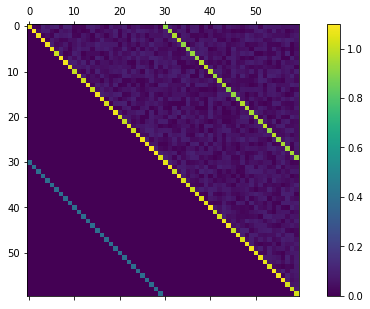

In [5]:
fig1, ax = plt.subplots(1, 1, figsize=(10,5))
cax = ax.matshow(Z)
fig1.colorbar(cax, ax=ax)
plt.savefig('matrix.pdf')
plt.show()

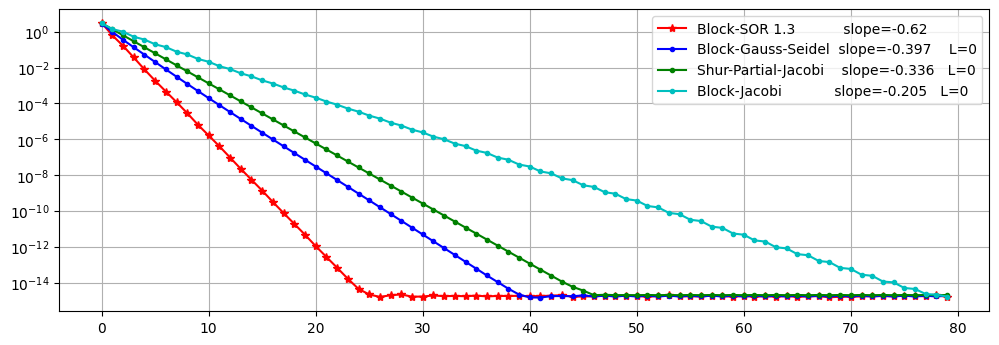

In [9]:
from scipy import stats

def slope(res):
    x = np.arange(len(res))
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,np.log10(res))
    return slope

nit = 80
Lvec = [0.4, 0.5]
clrs = ['r', 'b', 'g']

plt.figure(dpi=100, figsize=(12,4))

omega = 1.3
u_BJ,   v_BJ,   res_BJ   = method_BlockJacobi(nit,0)
u_BSOR, v_BSOR, res_BSOR = method_BlockSOR(nit, omega)
u_BGS,  v_BGS,  res_BGS  = method_BlockGaussSeidel(nit, 0)
u_SPJ,  v_SPJ,  res_SPJ  = method_ShurPartialJacobi(nit, 0)

nn = 20
l1 = slope(res_BSOR[:nn])
l2 = slope(res_BGS[:nn])
l3 = slope(res_SPJ[:nn])
l4 = slope(res_BJ[:nn])

plt.semilogy(res_BSOR, 'r*-', label=f"Block-SOR {omega}           slope={np.round(l1,3)}")
plt.semilogy(res_BGS, 'b.-', label=f"Block-Gauss-Seidel  slope={np.round(l2,3)}    L={0}")
plt.semilogy(res_SPJ, 'g.-', label=f"Shur-Partial-Jacobi    slope={np.round(l3,3)}   L={0}")
plt.semilogy(res_BJ,  'c.-', label=f"Block-Jacobi            slope={np.round(l4,3)}   L={0}")

plt.grid()
plt.legend()
plt.savefig('conv.pdf')
plt.show()